In [1]:
## Load any changes to local modules
%load_ext autoreload
%autoreload 2

import os
import sys

pwd = %pwd

module_path = os.path.abspath(os.path.join('{0}/../../'.format(pwd)))
if module_path not in sys.path:
    sys.path.append(module_path)

#study_dir = '{}/{}'.format(module_path, 'results/03072018_proteomics_informatics_tc/')

results_dir = '{}/{}'.format(module_path, 'results/hotspot_db/results')


In [2]:
from sqlalchemy import create_engine, MetaData, Table
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import configparser
%matplotlib inline

In [3]:
import math

%env HOME

'/home/jonesmic'

In [ ]:
class HotSpotReader:
    
    __mods = {'ISOHEAVY':470.29977, 'ISOLIGHT':464.28596}
    
    ## Include all mods -- excluding MET OX. 
    __mod_pattern = re.compile(r'((\d+),(\d+.\d+))')
    
    def __init__(self):
        
        config = configparser.ConfigParser()
        home = %env HOME
        file_path = '{}/.prds'.format(home)
        print(config.read(file_path))
        
        #for key in config['DEFAULT']: print(key)
            
        user = config['DEFAULT']['hotspotdb.user']
        password = config['DEFAULT']['hotspotdb.pass']
        
        url = 'mysql+pymysql://{}:{}@tintin.nibr.novartis.net/peptide_database'.format(user, password)
        self.engine = create_engine(url)
        
    def get_basic_peptide_data(self):
        sqlString = """
                       SELECT sequence, modifications_t, spectral_counts, experiment FROM peptide_database.peptide
                       WHERE modifications_t is not null
        
                    """
        print(sqlString)
        
        df = pd.read_sql(sqlString, self.engine.connect())
        
        return df
    
    def get_peptide_data_no_genes(self, experiment='AR_CA6_degrader/CA6_5_2017_08_09_18_2923'):
        
        exp_query = ""
        gene_join = ""
        if experiment:
            exp_query = " AND experiment = '{}'".format(experiment)
        
        sqlString = """

                SELECT
                sequence,
                modifications_t,
                spectral_counts,
                experiment,
                pr.uniprot_id,
                species
                FROM peptide p
                INNER JOIN association a ON p.id = a.peptide_id
                INNER JOIN protein pr ON a.protein_id = pr.uniprot_ID 
                WHERE modifications_t is not null
                {}
        """.format(exp_query)
        
        """and modifications_t is not null"""
        
        print(sqlString)
        
        df = pd.read_sql(sqlString, self.engine.connect())
        
        #df['ISOTOP_PEP'] = df.apply(self.__extract_probe_pep, axis=1)
        
        df['ISOTOP_PEP'] = df.apply(self.create_isotop_probe_pep, axis=1)
        df['MOD_PEP'] = df.apply(self.create_mod_pep, axis=1, include_type=False)
        df['TYPED_MOD_PEP'] = df.apply(self.create_mod_pep, axis=1, include_type=True)

        df['TYPED_MOD'] = df.TYPED_MOD_PEP.str.extract(r'[A-Z]_(.*)', expand=False)
        
        return df
    
    def get_peptide_data(self, experiment='AR_CA6_degrader/CA6_5_2017_08_09_18_2923'):
        
        exp_query = ""
        gene_join = ""
        if experiment:
            exp_query = " AND experiment = '{}'".format(experiment)
        
        sqlString = """

                SELECT
                sequence,
                modifications_t,
                spectral_counts,
                experiment,
                pr.uniprot_id,
                species,
                gene_name
                FROM peptide p
                INNER JOIN association a ON p.id = a.peptide_id
                INNER JOIN protein pr ON a.protein_id = pr.uniprot_ID 
                INNER JOIN gene_to_acc g ON a.protein_id = g.uniprot_id
                WHERE modifications_t is not null
                {}
        """.format(exp_query)
        
        """and modifications_t is not null"""
        
        print(sqlString)
        
        df = pd.read_sql(sqlString, self.engine.connect())
        
        #df['ISOTOP_PEP'] = df.apply(self.__extract_probe_pep, axis=1)
        
        df['ISOTOP_PEP'] = df.apply(self.create_isotop_probe_pep, axis=1)
        df['MOD_PEP'] = df.apply(self.create_mod_pep, axis=1, include_type=False)
        df['TYPED_MOD_PEP'] = df.apply(self.create_mod_pep, axis=1, include_type=True)
        df['TYPED_MOD'] = df.TYPED_MOD_PEP.str.extract(r'[A-Z]_(.*)', expand=False)
        df['MOD_TYPE'] = df.apply(self.create_mod_types, axis=1)
        
        
        return df
    
        
    def create_mod_pep(self, row, include_type=False):
        sequence = row['sequence']
        modifications = row['modifications_t']
        
        matches = self.__mod_pattern.findall(modifications)
        
        mods = []
        
        mod_type = None
        mod_pep = None
        for m in matches:
            position = int(m[1])
            aa = sequence[position]
            mass = float(m[2])
            for key in self.__mods.keys():
                mod_mass = self.__mods[key]
                if math.isclose(mod_mass, mass, rel_tol=1e-02):
                    mod_type = key
                
            if not mod_type:
                    mod_type = 'NS'
            
            mod_type = '{}_{:.2f}'.format(mod_type, mass)
            
            modstr = '{}{}_{}'.format(aa, position, mod_type) if include_type else '{}{}'.format(aa, position)
            mods.append(modstr)
            
        if len(mods) > 0:
            mod_pep = sequence + '_' + ','.join(str(p) for p in mods)
        
        return mod_pep
    

        
    def create_isotop_probe_pep(self, row):
        
        sequence = row['sequence']
        modifications = row['modifications_t']
        
        matches = self.__mod_pattern.findall(modifications)
        
        mods = []
        mod_pep = None
        for m in matches:
            position = int(m[1])
            if sequence[position] == 'C':
                mass = float(m[2])
                if mass in self.__mods.values():
                    mods.append('C{}'.format(position))
        if len(mods) > 0:
            mod_pep = sequence + '_' + ','.join(str(p) for p in mods)
        
        return mod_pep
    
    def create_mod_types(self, row):
        sequence = row['sequence']
        modifications = row['modifications_t']
        
        matches = self.__mod_pattern.findall(modifications)
        
        mods = []
        
        mod_type = None

        for m in matches:
            mass = float(m[2])
            position = int(m[1])
            aa = sequence[position]

            for key in self.__mods.keys():
                mod_mass = self.__mods[key]
                if math.isclose(mod_mass, mass, rel_tol=1e-02):
                    mod_type = '{}_{}_{:.2f}'.format(aa, key, mass)
                
            if not mod_type:
                    mod_type = mod_type = '{}_NS_{:.2f}'.format(aa, mass)
            
            mods.append(mod_type)
           
        mod_types = None

        mods = set(mods)
        if len(mods) > 0:
            mod_types = ','.join(p for p in mods)
        
        return mod_types
        
        
hotSpotReader = HotSpotReader()

#df = hotSpotReader.get_peptide_data(experiment='KEA_JLC_EN40_xenograft/EN40_1_2018_01_29_15_3160')


In [ ]:
## G

In [26]:
## Get data
#allDataDF = hotSpotReader.get_peptide_data(experiment=None)
#allDataDF['TYPED_MOD'] = allDataDF.TYPED_MOD_PEP.str.extract(r'[A-Z]_(.*)', expand=False)
#allDataDF['MOD_TYPE'] = allDataDF.apply(hotSpotReader.create_mod_types, axis=1)
file_path = '{}/all_data.txt'.format(results_dir)
#allDataDF.to_csv(file_path, sep='\t', index=False)
#display(allDataDF['MOD_TYPE'].head())

allDataDF = pd.read_table(file_path)

#allDataDF['TYPED_MOD_PEP'] = allDataDF.apply(hotSpotReader.create_mod_pep, axis=1, include_type=True)
#allDataDF['TYPED_MOD'] = allDataDF.TYPED_MOD_PEP.str.extract(r'[A-Z]_(.*)', expand=False)


#display(allDataDF.T)

#allDataDFNoGenes = hotSpotReader.get_peptide_data_no_genes(experiment=None)
#file_path = '{}/all_data_no_genes.txt'.format(results_dir)
#allDataDFNoGenes.to_csv(file_path, sep='\t', index=False)
#

#allPeptidesBasic = hotSpotReader.get_basic_peptide_data()

In [ ]:
#display(allDataDF.head())

mod_types = allDataDF['MOD_TYPE']
df = mod_types.value_counts().reset_index()
df.columns = ['MOD_TYPE', 'COUNT']

pattern = re.compile(r'([A-Z])_([A-Z]+)_(.+).*')

#display(df['MOD_TYPE'].str.extractall(pattern))

tmp = df['MOD_TYPE'].str.extractall(pattern)

df['AA'] = tmp.iloc[:,0].values
df['MOD'] = tmp.iloc[:,1].values
df['MASS'] = tmp.iloc[:,2].values

display(df.head())
file_path = '{}/typed_mods.txt'.format(results_dir)
df.to_csv(file_path, sep='\t', index=False)

In [ ]:
#allPeptidesBasic['MOD_PEP'] = allPeptidesBasic.apply(hotSpotReader.create_mod_pep, axis=1, include_type=False)

In [ ]:
#allDataDF['MOD_CLASS'] = allDataDF.apply(hotSpotReader.classify_mod, axis=1)


display(allDataDF.T)

display(set(allDataDF.species))
display(set(allDataDFNoGenes.species))

In [ ]:
mod_peptides = allPeptidesBasic.MOD_PEP
isotop_peptides = allPeptidesBasic[~allPeptidesBasic['ISOTOP_PEP'].isnull()].sequence

data = {'Type': ['Modified Peptide Sequences', 'isoTop Sequences'], 
        'Total': [len(mod_peptides), len(isotop_peptides)], 
        'Distinct': [len(set(mod_peptides)), len(set(isotop_peptides))]}

basic_count_df = pd.DataFrame(data=data)
basic_count_df = basic_count_df[['Type', 'Total', 'Distinct']]
display(basic_count_df)


In [ ]:
set(all)

In [ ]:
groups = allDataDF.groupby('species')

display(groups.uniprot_id.nunique())
display(groups.gene_name.nunique())
display(groups.sequence.nunique())
display(groups.MOD_PEP.nunique())
display(groups.TYPED_MOD_PEP.nunique())
display(groups.ISOTOP_PEP.nunique())

groups = allDataDFNoGenes.groupby('species')

print("Proteins only")

display(groups.uniprot_id.nunique())
display(groups.sequence.nunique())
display(groups.MOD_PEP.nunique())
display(groups.TYPED_MOD_PEP.nunique())
display(groups.ISOTOP_PEP.nunique())

In [35]:
allDataDF.columns

Index(['sequence', 'modifications_t', 'spectral_counts', 'experiment',
       'uniprot_id', 'species', 'gene_name', 'ISOTOP_PEP', 'MOD_PEP',
       'TYPED_MOD_PEP', 'MOD_TYPE', 'TYPED_MOD'],
      dtype='object')

In [36]:
count_dfs = {}

species_list = list(allDataDF['species'].unique())
#species_list = []
#species_list.append('all')

for species in species_list:

    selector = (allDataDF.species == species)
    if species == 'all':
        selector = (allDataDF.species == allDataDF.species)
        
        
    
    gps = allDataDF[selector].groupby(['sequence'])
    df = gps.experiment.nunique().reset_index()
    df.columns = ['peptide_sequence', '# experiments']
    #display(exp_per_pep_df.head())

    key = '{} peptide counts'.format(species)
    count_dfs[key] = df    
    
    gps = allDataDF[selector].groupby(['ISOTOP_PEP'])
    df = gps.experiment.nunique().reset_index()
    df.columns = ['mod_peptide', '# experiments']
    #display(exp_per_pep_df.head())

    key = '{} mod_peptide counts'.format(species)
    count_dfs[key] = df

    gps = allDataDF[selector].groupby(['gene_name'])
    df = gps.experiment.nunique().reset_index()
    df.columns = ['gene', '# experiments']
    
    key = '{} gene counts'.format(species)
    count_dfs[key] = df
    
    
for species in species_list:

    selector = (allDataDF.species == species)
    if species == 'all':
        selector = (allDataDF.species == allDataDF.species)
    
    gps = allDataDF[selector].groupby(['ISOTOP_PEP', ])
    df = gps.experiment.nunique().reset_index()
    df.columns = ['mod_peptide', '# experiments']
    #display(exp_per_pep_df.head())

    key = '{} mod_peptide counts_gt1'.format(species)
    count_dfs[key] = df

    gps = allDataDF[selector].groupby(['gene_name'])
    df = gps.experiment.nunique().reset_index()
    df.columns = ['gene', '# experiments']
    
    key = '{} gene counts_gt1'.format(species)
    count_dfs[key] = df



human peptide counts
Writing data /home/jonesmic/gBuild/jonesmic_github/proteomics-scripts/results/hotspot_db/results/human_peptide_counts.txt
total hotspot peptide=53,771 with < 31,738 (59.02%) in < 2 exps 
Writing data /home/jonesmic/gBuild/jonesmic_github/proteomics-scripts/results/hotspot_db/results/clipped_20_dist_human_peptide_counts.png
Writing data /home/jonesmic/gBuild/jonesmic_github/proteomics-scripts/results/hotspot_db/results/dist_human_peptide_counts.png
Writing data /home/jonesmic/gBuild/jonesmic_github/proteomics-scripts/results/hotspot_db/results/log_dist_human_peptide_counts.png
human mod_peptide counts
Writing data /home/jonesmic/gBuild/jonesmic_github/proteomics-scripts/results/hotspot_db/results/human_mod_peptide_counts.txt
total hotspot mod_peptide=46,856 with < 28,226 (60.24%) in < 2 exps 
Writing data /home/jonesmic/gBuild/jonesmic_github/proteomics-scripts/results/hotspot_db/results/clipped_20_dist_human_mod_peptide_counts.png
Writing data /home/jonesmic/gBuild

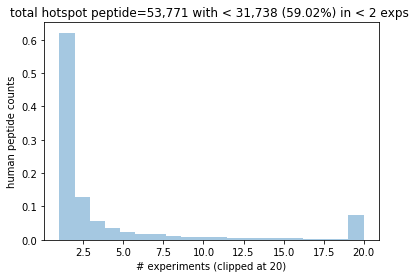

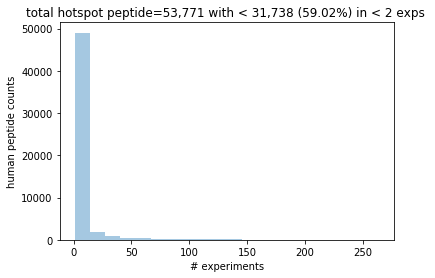

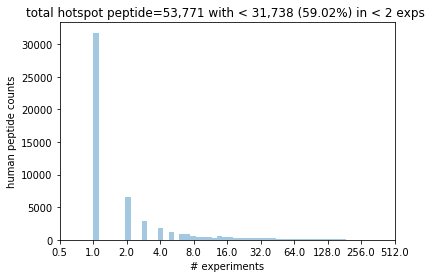

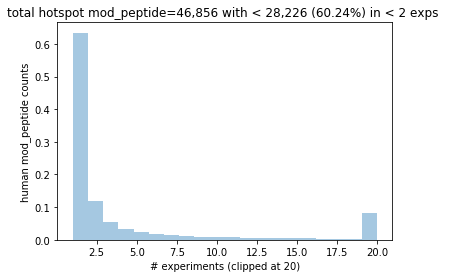

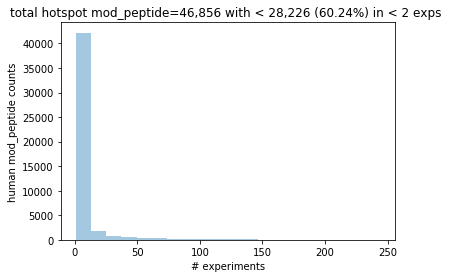

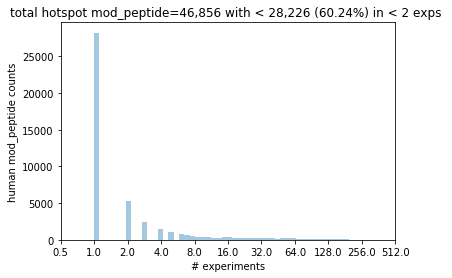

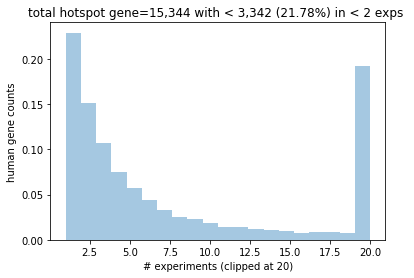

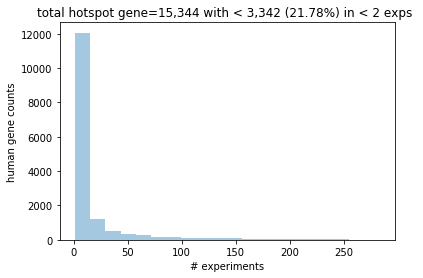

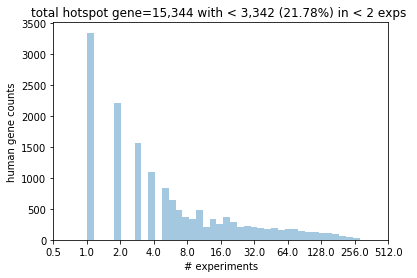

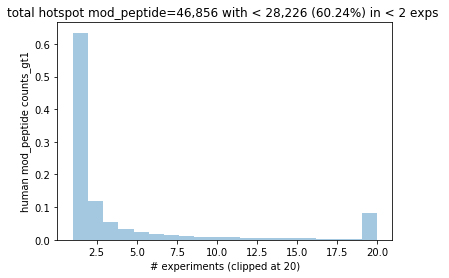

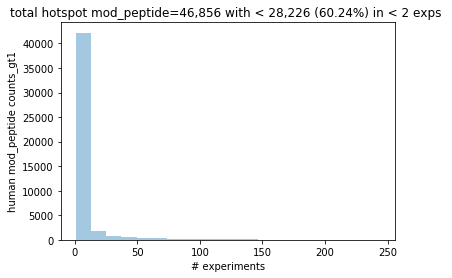

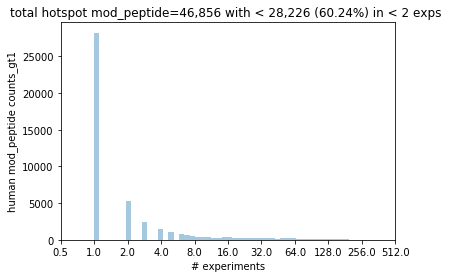

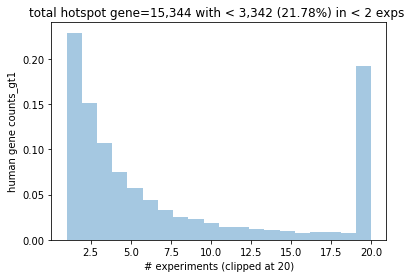

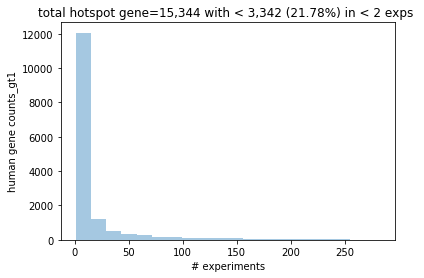

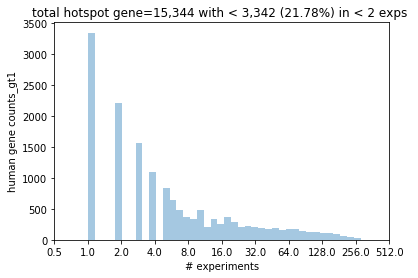

In [38]:
def do_dist_plots(df, cuttoff = 2, name=None):
    toks = name.split()
    feature_type = toks[1]
    
    file_path = '{}/{}.txt'.format(results_dir, name).replace(' ', '_')
    print('Writing data {}'.format(file_path))
    df.to_csv(file_path, sep='\t', index=False)
    
    totMultiExpCount = df[df['# experiments'] < cuttoff].index.size
    totCounts = df.index.size

    percentMultiExp = (totMultiExpCount / totCounts) * 100
    msg = 'total hotspot {}={:,} with < {:,} ({:.2f}%) in < {} exps '.format(feature_type, totCounts, totMultiExpCount, percentMultiExp,  cuttoff)    
    print(msg)
    
    s = pd.Series(data=df['# experiments'].clip(upper=20), name='# experiments (clipped at 20)')
    ax = sns.distplot(s, kde=False, norm_hist=True, bins=20)
    ax.set_title(msg)
    ax.set_ylabel(name)
   
    
    file_path = '{}/clipped_20_dist_{}.png'.format(results_dir, name).replace(' ', '_')
    print('Writing data {}'.format(file_path))
    plt.savefig(file_path, bbox_inches='tight')
    plt.figure()
    
    s = pd.Series(data=df['# experiments'], name='# experiments')
    ax = sns.distplot(s, kde=False, norm_hist=False, bins=20)
    ax.set_title(msg)
    ax.set_ylabel(name)

    
    file_path = '{}/dist_{}.png'.format(results_dir, name).replace(' ', '_')
    print('Writing data {}'.format(file_path))
    plt.savefig(file_path, bbox_inches='tight')
    plt.figure()
    
    ## Do Log plot
    s = pd.Series(data=df['# experiments'].apply(lambda x : np.log2(x)), name='# experiments')
    #s = pd.Series(data=df['# experiments'], name='# experiments')
    #ax = sns.distplot(s, kde=False, norm_hist=False)

    ax = sns.distplot(s, kde=False, norm_hist=False)
    ax.set_title(msg)
    #ax.set_xscale('log')
    #plt.xscale('log')
    ax.set_ylabel(name)
    plt.xticks(plt.xticks()[0],[2**i for i in plt.xticks()[0]]);
    
    #ax.set_xticklabels(['SDFSDFD'])
    
    
    #ax_max = max(ax.get_xticks())
    #step = ax_max / 15

    # Set the major ticks
    #major_ticks = np.arange(ax_max + 1, step=step)
    #ax.set_xticks(major_ticks)

    
    file_path = '{}/log_dist_{}.png'.format(results_dir, name).replace(' ', '_')
    print('Writing data {}'.format(file_path))
    plt.savefig(file_path, bbox_inches='tight')
        
    plt.figure()
    
    



## Add filter for exps with > then x
    
keys = count_dfs
for key in count_dfs.keys():
    print (key)
    df = count_dfs[key]
    do_dist_plots(df, name=key)

    
#do_count_plots(exp_per_pep_df, feature_type='peptide', ylabel='modified peptides')
#do_count_plots(human_exp_per_pep_df, feature_type='peptide', ylabel='human modified peptides')

In [ ]:
## Num genes / exp
gps = allDataDF.groupby('experiment')
df = gps.gene_name.nunique().reset_index()
df.columns = ['experiment', '# genes']
display(df.head())

cuttoff = 10
totSingleGeneCount = df[df['# genes'] < cuttoff].index.size
totCounts = df.index.size
percentSingleGene = (totSingleGeneCount / totCounts) * 100
msg = 'total num human exps {:,} with < {:,} ({:.2f}%) with < {} genes '.format(totCounts, totSingleGeneCount, percentSingleGene,  cuttoff)    


s = pd.Series(data=df['# genes'], name='# genes')
ax = sns.distplot(s, kde=False, norm_hist=False, bins=20)
ax.set_title(msg)
ax.set_ylabel('# experiments')


file_path = '{}/num_genes_exp.png'.format(results_dir).replace(' ', '_')
print('Writing data {}'.format(file_path))
plt.savefig(file_path, bbox_inches='tight')
plt.figure()



s = pd.Series(data=df['# genes'], name='log10(# genes)').apply(np.log10)
ax = sns.distplot(s, kde=False, norm_hist=False, bins=20)
ax.set_title(msg)
ax.set_ylabel('# experiments')


file_path = '{}/log_num_genes_exp.png'.format(results_dir).replace(' ', '_')
print('Writing data {}'.format(file_path))
plt.savefig(file_path, bbox_inches='tight')
plt.figure()



In [ ]:
cuttoff = 2
tmpDF = df[df['# Experiments / Gene'] < cuttoff]
totProts = len(set(df['Protein']))
totProtsMultiExp = len(set(tmpDF['Protein']))
percentMultiExp = (totProtsMultiExp / totProts) * 100

ax = sns.distplot(df['# Experiments / protein'], kde=False)

msg = 'Proteins, total={:,}. In < {} exps {:,} ({:.2f}%)'.format(totProts, cuttoff, totProtsMultiExp, percentMultiExp)


ax.set_title(msg)
plt.figure()


ax = sns.distplot(df['# Experiments / protein'], kde=True)
ax.set_title(msg)
plt.figure()



In [ ]:
## Do it only on human peps
gps = allDataDF[allDataDF.species == 'human'].groupby(['MOD_PEP'])

df = gps.experiment.nunique().reset_index()

#df.columns = ['Modified Peptide', 'Species', 'Number of experiments']
df.columns = ['Modified Peptide', '# Experiments / peptide']

display(df.head())


In [ ]:
ax = sns.countplot(x='MOD_TYPE', data=allDataDF, 
                  order= allDataDF['MOD_TYPE'].value_counts().index)
ax.set_title('Mod Classification')
ax.set_ylabel('Number of human peptides')
#ax.set_xticklabels(rotation=30)
plt.xticks(rotation=30)
plt.figure()

"""
ax = sns.countplot(x='MOD_CLASS', data=allDataDF[allDataDF.species != 'human'], 
                  order=allDataDF['MOD_CLASS'].value_counts().index)
ax.set_title('Mod Classification')
ax.set_ylabel('Number of non-human peptides')
#ax.set_xticklabels(rotation=30)
plt.xticks(rotation=30)
plt.figure()"""

## 

In [ ]:
allDataDF.columns

In [ ]:
gps = allDataDF[selector].groupby(['MOD_PEP'])

prot_counts = gps.uniprot_id.count().reset_index()
prot_counts.columns = [['MOD_PEP', '# of Proteins']]
display(prot_counts.head())
prot_counts = prot_counts[prot_counts['# of Proteins'] > 0]
display(prot_counts.head())
sns.distplot(prot_counts['# of Proteins'].apply(lambda x : np.log10(x+1)), kde=False)

In [ ]:

totMultiExpCount = df[df['# experiments'] < cuttoff].index.size
totCounts = df.index.size

percentMultiExp = (totMultiExpCount / totCounts) * 100
msg = 'total {}={:,} with < {:,} ({:.2f}%) in < {} exps '.format(feature_type, totCounts, totMultiExpCount, percentMultiExp,  cuttoff)    
    
    
s = pd.Series(data=df['# experiments'].clip(upper=20), name='# experiments (clipped at 20)')
ax = sns.distplot(s, kde=False, norm_hist=True, bins=20)
ax.set_title(msg)
ax.set_ylabel(name)
plt.figure()
    
    

In [ ]:

df = count_dfs['human mod_peptide counts']
display(df.columns)
df['# experiments'].min()

In [ ]:
df = allDataDF.head(1000)
s = df.apply(hotSpotReader.classify_mod, axis=1)
df[s == 'other']

In [ ]:
gps = allDataDF.groupby('experiment')
s = gps.uniprot_id.count().apply(np.log10)
s.name = 'EXP_COUNT'
display(s.head())

sns.distplot(s, kde=False, norm_hist=False)

In [ ]:
s[s == 0]

In [ ]:
allDataDF[allDataDF.uniprot_id]

In [ ]:
set(allDataDF.uniprot_id)

In [ ]:
def gene_report(gene=None):
    df = allDataDF[allDataDF.gene_name == gene]
    #display(df[df.sequence == 'KQVVIDGETCLLDILDTAGQEEYSAMRD'])
    
    grouped = df.groupby('sequence')
    
    data = {'gene':[], 'peptide':[], 'tot_pep_count':[], 
            'exp_count':[], 
            'uniq_exp_count':[],
            'mod':[]
           }
    
    for name, group in grouped:
        data['gene'].append(gene.upper())
        data['peptide'].append(name)
        data['tot_pep_count'].append(group['sequence'].count())
        data['mod'].append(set(df[df['sequence'] == name]['TYPED_MOD']))
        data['exp_count'].append(group['experiment'].count())
        data['uniq_exp_count'].append(group['experiment'].nunique())
        #display(group['experiment'].apply(lambda x :x))
        
    df = pd.DataFrame(data=data)
    df = df[['gene', 'peptide', 'tot_pep_count', 'mod', 'exp_count', 'uniq_exp_count']]
    return df
    
for gene in ['kras', 'esr2']:
    display('Gene report for {}'.format(gene.upper()))   
    df = gene_report(gene=gene)

    file_path = '{}/{}_gene_report.txt'.format(results_dir, gene)
    print('Writing data {}'.format(file_path))
    df.to_csv(file_path, sep="\t", index=False)
    display(df)

In [ ]:
allDataDF.columns

In [ ]:
allDataDF[allDataDF.sequence == 'RDAHFCAVCSDYASGYHYGVWSCEGCKA'].T

In [43]:
class TPPXML:
    
    def __init__(self):
        config = configparser.ConfigParser()
        home = %env HOME
        file_path = '{}/.prds'.format(home)
        config.read(file_path)

        user = config['DEFAULT']['tppxml.user']
        password = config['DEFAULT']['tppxml.pass']
        sid = config['DEFAULT']['tppxml.sid']
        
        url = 'oracle+cx_oracle://{user}:{pw}@{db}'.format(user=user, pw=password, db=sid)
        #print(url)
        
        self.engine = create_engine(url)
    
    def get_peptide_counts(self):
        
        sqlStr = "SELECT count(EXPERIMENT_TABLE_NAME), PEPTIDE FROM TPPXML.BASIC_ANALYSIS_PEPTIDE WHERE EXPERIMENT_TABLE_NAME IS NOT NULL GROUP BY PEPTIDE"
    
    def get_test(self):
        sqlStr = "SELECT * FROM TPPXML.BASIC_ANALYSIS_PEPTIDE bap WHERE bap.PEPTIDE = 'RVVLGDGVQLPPGDYSTTPGGTLFSTTPGGTR'"
        
        df = pd.read_sql(sqlStr, self.engine.connect())
        
        return df
    
    def get_pep_exp_count(self):
        sqlStr = "SELECT count(DISTINCT EXPERIMENT_TABLE_NAME), PEPTIDE FROM TPPXML.BASIC_ANALYSIS_PEPTIDE WHERE EXPERIMENT_TABLE_NAME IS NOT NULL GROUP BY PEPTIDE"
        
        df = pd.read_sql(sqlStr, self.engine.connect())
        
        return df
    
tppXml = TPPXML()

In [44]:
df = tppXml.get_pep_exp_count()

,COUNT(DISTINCTEXPERIMENT_TABLE_NAME),peptide
0,5,MKLLTHNLLSSHVR
1,106,KLEQLDWTVGLR
2,410,MVPTSDK
3,1,MFPAK
4,409,GGAVVDEGPTGVK


Writing data /home/jonesmic/gBuild/jonesmic_github/proteomics-scripts/results/hotspot_db/results/chemgx_peptide_per_exp_counts.txt
total ChemGx Peptides=753,793 with < 275,269 (36.52%) in < 2 exps 
Writing data /home/jonesmic/gBuild/jonesmic_github/proteomics-scripts/results/hotspot_db/results/chemgx_peptide_per_exp_counts.png


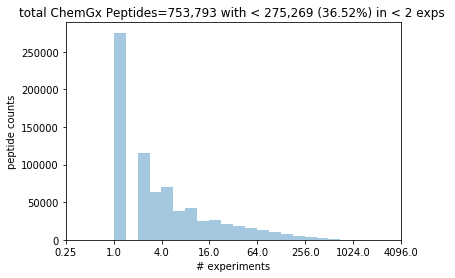

In [56]:
display(df.head())

 
file_path = '{}/{}.txt'.format(results_dir, 'chemgx_peptide_per_exp_counts')
print('Writing data {}'.format(file_path))
df.to_csv(file_path, sep='\t', index=False)
    

cuttoff = 2
totMultiExpCount = df[df['COUNT(DISTINCTEXPERIMENT_TABLE_NAME)'] < cuttoff].index.size
totCounts = df.index.size

percentMultiExp = (totMultiExpCount / totCounts) * 100
msg = 'total {}={:,} with < {:,} ({:.2f}%) in < {} exps '.format('ChemGx Peptides', totCounts, totMultiExpCount, percentMultiExp,  cuttoff)    
print(msg)

s = pd.Series(data=df['COUNT(DISTINCTEXPERIMENT_TABLE_NAME)'].apply(np.log2), name='# experiments')
ax = sns.distplot(s, kde=False, norm_hist=False, bins=20)
ax.set_title(msg)
ax.set_ylabel('peptide counts')
#ax.plot(range(0.25, 1359.0))

#plt.xlim((0.25, 1359))

plt.xticks(plt.xticks()[0],[2**i for i in plt.xticks()[0]]);

    
file_path = '{}/chemgx_peptide_per_exp_counts.png'.format(results_dir)
print('Writing data {}'.format(file_path))
plt.savefig(file_path, bbox_inches='tight')

plt.figure()


   

In [47]:
#df['COUNT(DISTINCTEXPERIMENT_TABLE_NAME)'].max()

1007

In [51]:
len(set(allDataDF.experiment))

363